Étapes d’EDA pour le projet Radar
-------------------------------------------------------------------------------------------------------

In [ ]:
# Données utilisées depuis le Bucket S3:
# df_competence_rome_eda.csv

In [6]:
# Install specific libraries for Amazon S3 connection:
%pip install boto3
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import os
from dotenv import load_dotenv
import boto3

In [3]:
# Modification des paramèters d'affichage de Pandas:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)
pd.set_option("display.max_colwidth", None)

In [4]:
# Load environment variables with specific location depend on EDI (PyCharm/VSCode)
if not load_dotenv('../settings/.env'):
    print("Load env from alternative from path")
    load_dotenv('script/settings/.env')

# Check settings (for debug session only)
if __debug__:
    print('Debug ON')
    print("Environment data:", 
        "\nS3_ENDPOINT_URL:", os.getenv("S3_ENDPOINT_URL"),
        "\nS3_ACCESS_KEY_ID (len):", len(os.getenv("S3_ACCESS_KEY_ID")), "bytes",
        "\nS3_SECRET_ACCESS_KEY (len):", len(os.getenv("S3_SECRET_ACCESS_KEY")), "bytes",
        "\nS3_REGION:", os.getenv("S3_REGION")
        )

Debug ON
Environment data: 
S3_ENDPOINT_URL: https://bhckzdwrhhfaxbidmwpm.supabase.co/storage/v1/s3 
S3_ACCESS_KEY_ID (len): 32 bytes 
S3_SECRET_ACCESS_KEY (len): 64 bytes 
S3_REGION: eu-west-3


In [5]:
# Init S3 client 
try:
    s3_client = boto3.client(
        service_name='s3',
        region_name=os.getenv("S3_REGION"),
        endpoint_url=os.getenv("S3_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("S3_ACCESS_KEY_ID"), 
        aws_secret_access_key=os.getenv("S3_SECRET_ACCESS_KEY")
    ) 
except Exception as ex:
    print(ex)

# Define function to read ROME CSV files
def read_ml_from_s3(s3_file_key):
    bucket_name = 'ML'
    s3_ml_path = ''

    try:
        obj = s3_client.get_object(Bucket= bucket_name, Key= s3_ml_path + s3_file_key)
        df = pd.read_csv(io.BytesIO(obj['Body'].read()))
        return df
    except Exception as ex:
        print("Erreur de lecture du fichier depuis le buecket S3:")
        print("->", ex)
    
    return None

# S3 CSV reading test
df = read_ml_from_s3( 'df_competence_rome_eda.csv')
if df is not None:
    print("Lecture du fichier réussi:")
    print(f"-> CSV: Nb de lignes: {df.shape[0]}, Nb de colonnes: {df.shape[1]}")

Lecture du fichier réussi:
-> CSV: Nb de lignes: 38961, Nb de colonnes: 15


In [6]:
# On récupère les données qui nous seront utiles
file_path_name = 'df_competence_rome_eda.csv'

try:
    df = read_ml_from_s3( file_path_name)
    print(f"Arborescence: Nb de lignes: {df.shape[0]}, Nb de colonnes: {df.shape[1]}")
except:
    print('Erreur lors de la lecture du fichier!')

Arborescence: Nb de lignes: 38961, Nb de colonnes: 15


## Analyse de la forme

### 1. Inspection et qualité des données

 - Vérifier les dimensions du dataset (lignes, colonnes).
 - Vérifier les types de variables (catégorielles vs numériques).
 - Rechercher les valeurs manquantes (NaN) et décider : suppression / imputation.
 - Détecter les doublons éventuels (par exemple mêmes couples code_rome–code_ogr_competence).
 - Vérifier la cohérence des clés (chaque code_rome existe bien, chaque code_ogr_competence est relié).

In [7]:
# 1. Inspection et qualité des données
# Vérifier les dimensions du dataset (lignes, colonnes).
print(f"Nombre de lignes: {df.shape[0]}, nb de colonnes: {df.shape[1]}")

Nombre de lignes: 38961, nb de colonnes: 15


In [8]:
# Vérifier les types de variables (catégorielles vs numériques).
df.dtypes

Unnamed: 0                   int64
code_rome                   object
libelle_rome                object
emploi_cadre                object
code_ogr_competence          int64
libelle_competence          object
cat_comp                    object
sous_cat_comp               object
libelle_macro_competence    object
domaine_competence          object
coeur_metier                object
transition_eco_x            object
transition_num_x            object
transition_eco_y            object
transition_num_y            object
dtype: object

In [9]:
# Afficher les première lignes du dataset:
df.head(20)

,Unnamed: 0,code_rome,libelle_rome,emploi_cadre,code_ogr_competence,libelle_competence,cat_comp,sous_cat_comp,libelle_macro_competence,domaine_competence,coeur_metier,transition_eco_x,transition_num_x,transition_eco_y,transition_num_y
0,0,A1101,Conducteur / Conductrice d'engins agricoles,NaN,104016,Contrôler le fonctionnement d'un dispositif de sécurité,Savoir-faire,Technique expert,"Contrôler le fonctionnement d'un équipement, d'une machine, d'une installation","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
1,1,A1101,Conducteur / Conductrice d'engins agricoles,NaN,107141,Entretenir les mécanismes d'un engin motorisé,Savoir-faire,Technique,"Entretenir un équipement, une machine, une installation","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
2,2,A1101,Conducteur / Conductrice d'engins agricoles,NaN,110024,Conduire un poids lourd,Savoir-faire,Technique,Conduire un véhicule routier,"Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
3,3,A1101,Conducteur / Conductrice d'engins agricoles,NaN,117548,Stocker un produit,Savoir-faire,Technique,"Trier, ranger des produits, des matières premières","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
4,4,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122567,Débroussailler une plantation et ses chemins d'accès,Savoir-faire,Technique,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,O,N
5,5,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122568,Contrôler l'état d'une plantation,Savoir-faire,Technique,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
6,6,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122573,"Planifier une opération de semis, de traitement ou de récolte sur un site d'exploitation",Savoir-faire,Technique expert,"Elaborer et planifier un programme de production, d'exploitation","Production, Construction, Qualité, Logistique",Principale,Emploi Blanc,NaN,NaN,N
7,7,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122730,"Préparer les sols, les plantations (épandage, semis, etc.)",Savoir-faire,Technique,Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale,Emploi Blanc,NaN,NaN,N
8,8,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122817,Réaliser des travaux d'aménagement,Savoir-faire,Technique,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
9,9,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122853,Récolter un produit à maturité et selon les consignes de calibrage,Savoir-faire,Technique,Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale,Emploi Blanc,NaN,NaN,N


Unnamed: 0                   0.00
code_rome                    0.00
libelle_rome                 0.00
code_ogr_competence          0.00
libelle_competence           0.00
cat_comp                     0.00
sous_cat_comp                0.00
libelle_macro_competence     0.00
domaine_competence           0.00
transition_eco_x             0.19
emploi_cadre                 7.86
transition_num_x             9.98
transition_num_y            15.01
transition_eco_y            58.03
coeur_metier                58.83
dtype: float64


<Axes: >

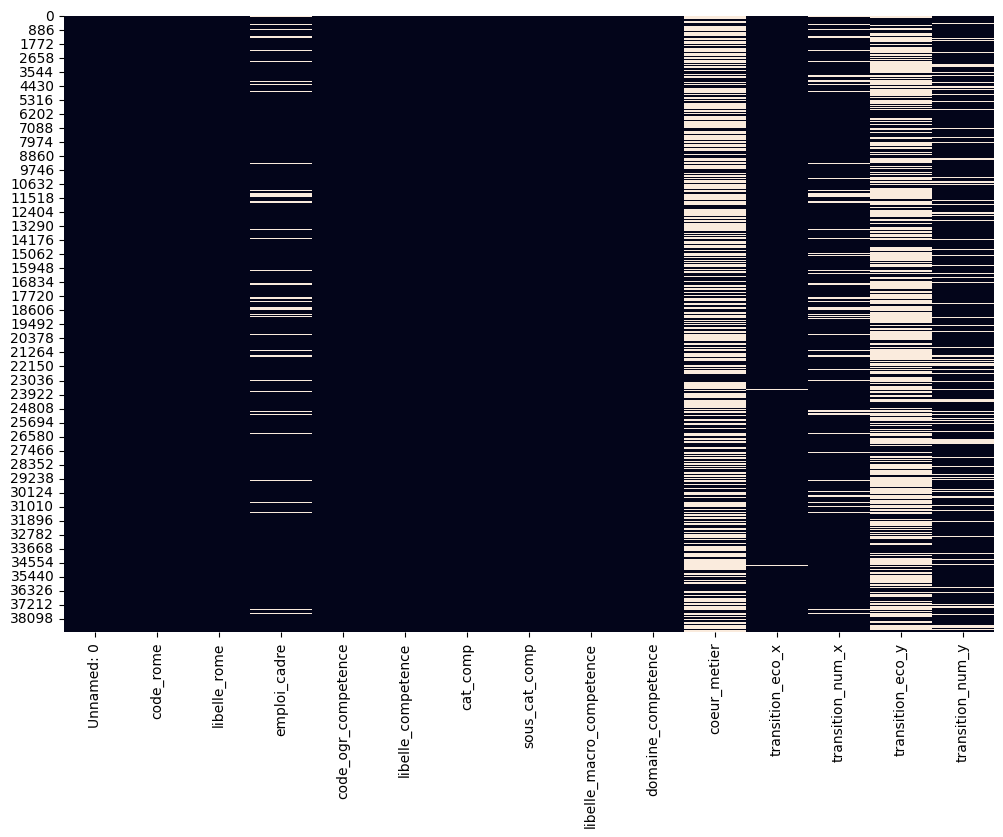

In [10]:
# Rechercher les valeurs manquantes (NaN) et décider : suppression / imputation.

# Taux de valeur nulles (en %):
df_nan = (df.isna().sum()/df.shape[0]).sort_values(ascending= True)
df_nan = df_nan * 100
print(f"{df_nan.round(2)}")

# Heat map
plt.figure(figsize=(12,8))
sns.heatmap(df.isna(), cbar= False)

# Analyse de la colonne 'emploi_cadre'

In [11]:
# Lister les valeurs
print("Nb de valeur:")
print(f"{df['emploi_cadre'].value_counts()}")

print("Nb de valeur nulles:", f"{df['emploi_cadre'].isna().sum()}")

Nb de valeur:
emploi_cadre
N    22053
O    13847
Name: count, dtype: int64
Nb de valeur nulles: 3061


In [12]:
df_code_rome = df.groupby('code_rome').count()
nb_code_rome = df_code_rome.shape[0]
print(f"Nombre de code rome unique: {nb_code_rome}")

Nombre de code rome unique: 1584


In [13]:
# Visualiser les emploi non cadre (N):
df_non_cadre = df.loc[df["emploi_cadre"] == "N", "code_rome"].drop_duplicates()
code_rome_non_cadre = df_non_cadre.count()
print("code_rome non cadre=", code_rome_non_cadre)
df_cadre = df.loc[df["emploi_cadre"] == "O", "code_rome"].drop_duplicates()
code_rome_cadre = df_cadre.count()
print("code_rome cadre=", code_rome_cadre)
df_cadre_nan = df.loc[df["emploi_cadre"].isna(), "code_rome"].drop_duplicates()
code_rome_cadre_nan = df_cadre_nan.count()
print("code_rome NaN=", code_rome_cadre_nan)

print(f"Différence: {code_rome_cadre_nan + code_rome_non_cadre + code_rome_cadre} sur {nb_code_rome} code_rome au total")

# -> Tous les code_rome sont soit 'cadre', soit 'non cadre', soit 'NaN'. Il n'y a pas de code_rome avec des emploi_cadre mixte.

code_rome non cadre= 861
code_rome cadre= 549
code_rome NaN= 174
Différence: 1584 sur 1584 code_rome au total


In [14]:
df_non_cadre = df.loc[df["emploi_cadre"] == "N", "libelle_competence"]
print(df_non_cadre)

# -> Les "emploi_cadre" à 'N' sont attribués aux compétences et non pas au code_rome

37                                                           Abattre un arbre
38                                                         Tailler les arbres
39                    Contrôler le fonctionnement d'un dispositif de sécurité
40                                                         Débarder une grume
41                                                         Empiler des grumes
                                         ...                                 
38956       Evaluer les risques liés aux différentes opérations sur le réseau
38957                       Appliquer les protocoles de sécurité ferroviaires
38958                                   Atteler/dételer les wagons d'un train
38959    Identifier des dangers, problèmes ou besoins matériels et techniques
38960          Respecter les procédures et les règles de sécurité ferroviaire
Name: libelle_competence, Length: 22053, dtype: object


# Analyse de la colonne 'coeur_metier'

In [15]:
# Lister les valeurs
print("Nb de valeur:")
print(f"{df['coeur_metier'].value_counts()}")
print("Nb de valeur nulles:")
print(f"{df['coeur_metier'].isna().sum()}")

Nb de valeur:
coeur_metier
Principale    14768
Émergente      1271
Name: count, dtype: int64
Nb de valeur nulles:
22922


In [16]:
# Visualiser les compétences émergentes:
df_emergente = df[df['coeur_metier'] == "Émergente"].groupby('libelle_competence')[['libelle_competence', 'coeur_metier']]
df_emergente.head(30)

,libelle_competence,coeur_metier
55,Identifier les opérations à réaliser à partir des diagnostics et des données fournies par un drone,Émergente
59,Gérer les déchets forestiers de manière écologique,Émergente
61,Promouvoir les pratiques de gestion durable auprès des propriétaires forestiers,Émergente
80,Gérer les ressources naturelles de manière durable,Émergente
110,Gérer les déchets végétaux de manière écologique,Émergente
...,...,...
38430,Sensibiliser au bien-être animal,Émergente
38520,Appliquer les principes d'écoconduite,Émergente
38710,Utiliser des systèmes de navigation avancés pour optimiser les parcours,Émergente
38779,Mettre en place une politique éco-responsable,Émergente


In [17]:
# Visualiser les compétences principale:
df_principale = df[df['coeur_metier'] == "Principale"].groupby('libelle_competence')[['libelle_competence', 'coeur_metier']]
df_principale.head(30)

,libelle_competence,coeur_metier
6,"Planifier une opération de semis, de traitement ou de récolte sur un site d'exploitation",Principale
7,"Préparer les sols, les plantations (épandage, semis, etc.)",Principale
9,Récolter un produit à maturité et selon les consignes de calibrage,Principale
11,"Effectuer des opérations agricoles (semis, récoltes)",Principale
12,Régler les systèmes hydrauliques des machines agricoles,Principale
...,...,...
38955,Coordonner les opérations de manœuvre pour l'assemblage des trains,Principale
38956,Evaluer les risques liés aux différentes opérations sur le réseau,Principale
38957,Appliquer les protocoles de sécurité ferroviaires,Principale
38958,Atteler/dételer les wagons d'un train,Principale


In [18]:
# Visualiser les compétences NaN:
df_principale = df[df['coeur_metier'].isna()].groupby('libelle_competence')[['libelle_competence', 'coeur_metier']]
df_principale.head(30)

,libelle_competence,coeur_metier
0,Contrôler le fonctionnement d'un dispositif de sécurité,NaN
1,Entretenir les mécanismes d'un engin motorisé,NaN
2,Conduire un poids lourd,NaN
3,Stocker un produit,NaN
4,Débroussailler une plantation et ses chemins d'accès,NaN
...,...,...
38948,Communiquer efficacement avec les passagers et la gare opposée,NaN
38951,Coordonner les opérations de chargement et de déchargement,NaN
38953,Assurer la sécurité des opérations de chargement et déchargement,NaN
38954,Superviser les opérations de chargement et de déchargement des marchandises,NaN


In [19]:
# Visualiser les nombres de valeurs non nulles de chaque colonne par code_rome:
df.groupby('code_rome').count()

,Unnamed: 0,libelle_rome,emploi_cadre,code_ogr_competence,libelle_competence,cat_comp,sous_cat_comp,libelle_macro_competence,domaine_competence,coeur_metier,transition_eco_x,transition_num_x,transition_eco_y,transition_num_y
code_rome,,,,,,,,,,,,,,
A1101,19,19,0,19,19,19,19,19,19,7,19,0,3,16
A1102,18,18,0,18,18,18,18,18,18,5,18,0,5,17
A1201,26,26,26,26,26,26,26,26,26,10,26,26,10,26
A1202,24,24,24,24,24,24,24,24,24,7,24,24,11,21
A1203,29,29,29,29,29,29,29,29,29,10,29,29,13,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N4304,15,15,15,15,15,15,15,15,15,9,15,15,12,14
N4305,7,7,0,7,7,7,7,7,7,5,7,0,2,4
N4401,6,6,0,6,6,6,6,6,6,4,6,0,0,6


In [20]:
# Nombre de code_rome sans coeur_metier de type 'Principale':
df_principale = df.groupby("libelle_rome")["coeur_metier"].apply(lambda x: (x == "Principale").sum()).reset_index()
df_principale[df_principale['coeur_metier'] == 0]

,libelle_rome,coeur_metier
316,Chef / Cheffe d'escale,0
430,Concierge d'hôtel,0
431,Conducteur / Conductrice Véhicule Léger de l'armée,0
463,Conducteur / Conductrice de navette de moins de 9 personnes,0
728,Electricien / Electricienne de maintenance,0


In [ ]:
# -> Il n'y a que 5 métiers (sur 1584) qui n'ont pas de compétence 'Principale'
# -> Remplacer les valeurs NaN par une valeur (ex: 'Secondaire').

### Analyse de la colonne 'transition_eco'

In [22]:
# Lister les valeurs
print("Nb de valeur transition_eco_x:")
print(f"{df['transition_eco_x'].value_counts()}")
print("Nb de valeur nulles transition_eco_x:", f"{df['transition_eco_x'].isna().sum()}")

print("\nNb de valeur transition_eco_y:")
print(f"{df['transition_eco_y'].value_counts()}")
print("Nb de valeur nulles transition_eco_y:", f"{df['transition_eco_y'].isna().sum()}")

Nb de valeur transition_eco_x:
transition_eco_x
Emploi Blanc                                        28941
Emploi stratégique pour la Transition écologique     6610
Emploi Vert                                          2538
Emploi Brun                                           797
Name: count, dtype: int64
Nb de valeur nulles transition_eco_x: 75

Nb de valeur transition_eco_y:
transition_eco_y
N    13958
O     2393
Name: count, dtype: int64
Nb de valeur nulles transition_eco_y: 22610


 Définitions:
 - `Emplois verts` → métiers directement liés à la protection de l’environnement ou à la gestion des ressources naturelles (ex. technicien en traitement des déchets, chargé d’études environnement, énergies renouvelables).
 - `Emplois verdissants / stratégiques pour la transition écologique` → métiers “classiques” qui doivent évoluer fortement pour intégrer des compétences environnementales (ex. bâtiment, transports, agriculture).
 - `Emplois bruns` → métiers qui ont un impact environnemental négatif marqué, souvent associés à des secteurs très émetteurs (raffinage, extraction fossile, certaines industries lourdes).
 - `Emplois blancs` → tous les autres métiers, sans lien direct avec l’écologie, ni dans le positif, ni dans le négatif (ex. coiffeur, comptable, professeur).

In [23]:
# Nombre de code_rome sans valeur de transition ecologique ('transition_eco_x' is NaN pour toutes les compétences du code_rome):
df_principale = df.groupby("libelle_rome")["transition_eco_x"].apply(lambda x: (x.isna() == False).sum()).reset_index()
df_principale[df_principale['transition_eco_x'] == 0]

# -> 3 code_rome sans valeur de transition_ecologique_x: c'est négligeable, on les considérera comme 'Emploi Blanc', sans impact direct sur l'écologie.

,libelle_rome,transition_eco_x
293,Chargé / Chargée des relations avec les influenceurs,0
562,Coordinateur / Coordinatrice en activité physique adaptée,0
754,Enseignant / Enseignante en activité physique adaptée (EAPA),0


In [24]:
# Nombre de code_rome sans valeur de transition ecologique ('transition_eco_y' is NaN pour toutes les compétences du code_rome):
df_principale = df.groupby("libelle_rome")["transition_eco_y"].apply(lambda x: (x.isna() == False).sum()).reset_index()
df_principale[df_principale['transition_eco_y'] == 0]

# -> 169 code_rome sans valeur de transition-ecologique_y

,libelle_rome,transition_eco_y
1,Accompagnant / Accompagnante des élèves en situation de handicap (AESH),0
10,Actuaire,0
45,Agent / Agente de fabrication du verre,0
46,Agent / Agente de façonnage et routage,0
48,Agent / Agente de la force publique,0
...,...,...
1565,Vendeur / Vendeuse d'articles de sport et loisirs,0
1568,Vendeur / Vendeuse en prêt-à-porter,0
1570,Vendeur / Vendeuse en épicerie,0
1571,Vendeur / Vendeuse en équipement de la maison,0


In [25]:
# 
tableau = pd.crosstab(
    df["transition_eco_x"], # referentiel_code_rome
    df["transition_eco_y"], # referentiel_competence
    dropna=False
)
 
print(tableau)

transition_eco_y                                      N    O    NaN
transition_eco_x                                                   
Emploi Blanc                                      11153  979  16809
Emploi Brun                                         194   41    562
Emploi Vert                                         585  733   1220
Emploi stratégique pour la Transition écologique   2001  639   3970
NaN                                                  25    1     49


### Résultat de la lecture:
Lors de l’analyse des variables liées à la transition écologique, nous avons comparé deux colonnes issues de sources différentes :

transition_eco_x (au niveau des métiers – code ROME)

transition_eco_y (au niveau des compétences – référentiel compétence)

L’analyse croisée met en évidence que :

La colonne transition_eco_y contient une très forte proportion de valeurs manquantes (NaN).
Cela limite fortement son exploitation directe, car la majorité des compétences n’ont pas d’indication explicite de transition écologique.

La colonne transition_eco_x est beaucoup plus robuste.
Elle catégorise chaque métier en Emploi Blanc, Emploi Brun, Emploi Vert ou Emploi stratégique pour la Transition écologique.
Cette classification couvre bien l’ensemble des métiers et ne présente que très peu de valeurs manquantes.

Pour les analyses et la modélisation, il est donc plus pertinent d’utiliser transition_eco_x comme variable principale pour identifier les métiers en lien avec la transition écologique.
La colonne transition_eco_y pourra éventuellement être exploitée en complément, mais uniquement à titre exploratoire, compte tenu de son caractère lacunaire.

`-> Il faudra supprimer la colonne transition_eco_y`

In [26]:
# -> La colonnes transition_eco_y, provenant de referentiel_competence, n'est pas utilisable car elle contient trop de valeur non définies (+ de 58%).
# -> Il faudra utiliser la colonne transition_eco_x qui est liée au code_rome et ne contient que 3 code_rome sans transition éco. de définie (- de 0.2%).

### Analyse des colonnes 'transition_num'

In [27]:
# Lister les valeurs
print("Nb de valeur transition_num_x (referentiel_code_rome):")
print(f"{df['transition_num_x'].value_counts()}")
print("Nb de valeur nulles transition_num_x:", f"{df['transition_num_x'].isna().sum()}")

print("\nNb de valeur transition_num_y (referentiel_competence):")
print(f"{df['transition_num_y'].value_counts()}")
print("Nb de valeur nulles transition_num_y:", f"{df['transition_num_y'].isna().sum()}")

Nb de valeur transition_num_x (referentiel_code_rome):
transition_num_x
N    30341
O     4730
Name: count, dtype: int64
Nb de valeur nulles transition_num_x: 3890

Nb de valeur transition_num_y (referentiel_competence):
transition_num_y
N    29535
O     3579
Name: count, dtype: int64
Nb de valeur nulles transition_num_y: 5847


In [28]:
# 
tableau = pd.crosstab(
    df["transition_num_x"], # referentiel_code_rome
    df["transition_num_y"], # referentiel_competence
    dropna=False
)
 
print(tableau)

transition_num_y      N     O   NaN
transition_num_x                   
N                 23825  1544  4972
O                  2282  1908   540
NaN                3428   127   335


In [29]:
# -> Il faudra faire un choix car il y 15% de valeur NaN pour la colonne transition_num_y.

In [33]:
# Nombre de code_rome sans valeur de transition numérique ('transition_num_x' is NaN pour ces code_rome):
df_numerique = df.groupby("libelle_rome")["transition_num_x"].apply(lambda x: (x.isna() == False).sum()).reset_index()
df_numerique_na = df_numerique[df_numerique['transition_num_x'] == 0]
df_numerique_na

,libelle_rome,transition_num_x
1,Accompagnant / Accompagnante des élèves en situation de handicap (AESH),0
10,Actuaire,0
38,Agent / Agente d'exploitation transport routier de personnes,0
39,Agent / Agente de conditionnement,0
45,Agent / Agente de fabrication du verre,0
...,...,...
1568,Vendeur / Vendeuse en prêt-à-porter,0
1570,Vendeur / Vendeuse en épicerie,0
1571,Vendeur / Vendeuse en équipement de la maison,0
1575,Viticulteur / Viticultrice,0


In [39]:
print(f"Pourcentage de valeur manquante: {df_numerique_na.shape[0]/df_numerique.shape[0]*100:.2f}%")

Pourcentage de valeur manquante: 14.02%


In [ ]:
# -> 222 métiers n'ont pas de transition numérique (NaN) sur 1584, soit 14%.

In [ ]:
# Nombre de code_rome sans valeur de transition numérique ('transition_num_y' is NaN pour toutes les compétences du code_rome):
df_principale = df.groupby("libelle_rome")["transition_num_y"].apply(lambda x: (x.isna() == False).sum()).reset_index()
df_principale[df_principale['transition_num_y'] == 0]

,libelle_rome,transition_num_y
516,Conseiller / Conseillère produits en véhicules,0
1427,Spécialiste de l’aide au déploiement des forces combattantes,0
1428,Spécialiste des systèmes de communication opérationnels,0
1430,Spécialiste du soutien ou de la formation propulsion nucléaire,0


In [ ]:
# Ces métiers devraient avoir des compétences identifiées en 'transition numérique'.
# -> Les données ne semblent pas complètes, difficiles à utiliser en l'état.

### Résultat de la lecture:
Lors de l’analyse des variables liées à la transition numérique, nous avons comparé deux colonnes issues de sources différentes :

transition_num_x (au niveau des métiers – code ROME)

transition_num_y (au niveau des compétences – référentiel compétence)

L’analyse croisée met en évidence que :

Comme pour la transition écologique, transition_num_x (au niveau métier) est l’indicateur le plus robuste, tandis que transition_num_y (au niveau compétence) présente trop de valeurs manquantes (=15 %) pour être utilisée comme variable principale.

Cependant, la colonne transition_num_x semble incomplète car nous avons identifié des métiers qui devraient avoir au moins une compétence en 'transition numérique'.
Nous considérons cette colonne non utilisable.

In [40]:
# Détecter les doublons éventuels (par exemple mêmes couples et code_rome code_ogr_competence).
# Doublons sur code_rome + code_ogr_competence
doublons_cles = df.duplicated(subset=['code_rome', 'code_ogr_competence']).sum()
print("Nombre de doublons sur (code_rome, code_ogr_competence) :", doublons_cles)

Nombre de doublons sur (code_rome, code_ogr_competence) : 0


In [41]:
# -> Pour un même code_rome, il n'y a pas plusieurs fois la même compétence

In [42]:
# Vérifier la cohérence des clés (chaque code_rome existe bien, chaque code_ogr_competence est relié).

# 5. Cohérence des clés
print("\nNombre de métiers uniques (code_rome) :", df['code_rome'].nunique())
print("Nombre de compétences uniques (code_ogr_competence) :", df['code_ogr_competence'].nunique())
 
# Vérification des clés manquantes
if df['code_rome'].isna().any() or df['code_ogr_competence'].isna().any():
    print("Attention : Codes manquants dans code_rome ou code_ogr_competence !")
else:
    print("Tous les codes_rome et code_ogr_competence sont présents.")
    


Nombre de métiers uniques (code_rome) : 1584
Nombre de compétences uniques (code_ogr_competence) : 16583
Tous les codes_rome et code_ogr_competence sont présents.


In [43]:
# -> Le dataframe ne contient pas de code_rome à NaN ce qui est normal car nous l'avons créé avec une jointure interne.
# -> Idem pour les code_ogr_competence.

### 2. Analyse descriptive générale

 - Nombre total de métiers (code_rome distincts).
 - Nombre total de compétences (code_ogr_competence distincts).
 - Nombre moyen de compétences par métier.
 - Nombre de domaines (domaine_competence).
 - Répartition compétences coeur vs secondaires (coeur_metier).

In [44]:
# Nombre total de métiers (code_rome distincts).
nb_code_rome = df['code_rome'].nunique()
print("\nNombre de code_rome uniques :", nb_code_rome)


Nombre de code_rome uniques : 1584


In [45]:
# Nombre total de compétences (code_ogr_competence distincts).
nb_competence = df['code_ogr_competence'].nunique()
print("Nombre de compétences uniques (code_ogr_competence) :", nb_competence)

Nombre de compétences uniques (code_ogr_competence) : 16583


In [48]:
# Nombre moyen de compétences par métier.
competences_par_metier = df.groupby('code_rome').size()
moyenne_competences = competences_par_metier.mean()
print(f"Nombre de compétence moyen par métier : {moyenne_competences:.1f}")

Nombre de compétence moyen par métier : 24.6


In [49]:
# Statistiques supplémentaires sur les compétences par métier
print("\nStatistiques sur le nombre de compétences par métier :")
print(competences_par_metier.describe())


Statistiques sur le nombre de compétences par métier :
count    1584.000000
mean       24.596591
std         9.758396
min         5.000000
25%        18.000000
50%        23.000000
75%        30.000000
max        82.000000
dtype: float64


In [50]:
# Nombre de domaines (domaine_competence).
nb_domaine_competence = df['domaine_competence'].nunique()
print("Nombre de domaine de compétences uniques (domaine_competence) :", nb_domaine_competence)

Nombre de domaine de compétences uniques (domaine_competence) : 6


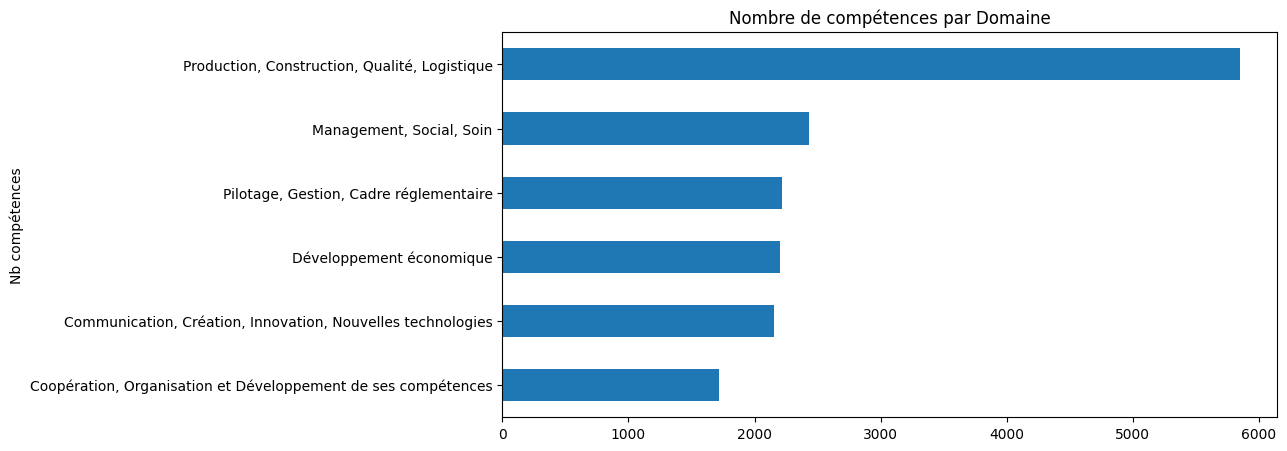

In [ ]:
# Compter le nombre de compétences par domaine
comp_par_domaine = (
    df.groupby(["domaine_competence"])["code_ogr_competence"]
    .nunique()
    .sort_values(ascending= True)
)
# Graphique par domaine
comp_par_domaine.plot(
    kind="barh", figsize=(10,5), title="Nombre de compétences par Domaine", 
)
plt.ylabel("Nb compétences")
plt.show()

### Lecture du résultat:
 - Il y a 6 domaines de compétences différents.
 - 'Production, Construction, Qualité, Logistique' est le domaine de compétence qui contient le plus de compétences différentes (presque 6000), et qui a la plus grande variété de compétences.
 - 'Coopération, Organisation et Développement de ses compétences' est celui qui en compte le moins (~1800)

In [ ]:
# Répartition compétences coeur vs secondaires (coeur_metier).
# Comptage des valeurs dans la colonne coeur_metier
repartition_coeur = df['coeur_metier'].value_counts(dropna=False)
print("\nRépartition des compétences (coeur_metier) :")
print(repartition_coeur)


Répartition des compétences (coeur_metier) :
coeur_metier
NaN           22922
Principale    14768
Émergente      1271
Name: count, dtype: int64


-> Les valeurs NaN ne traduisent pas une donnée manquante mais correspondent à une catégorie spécifique que nous considérons comme secondaires.

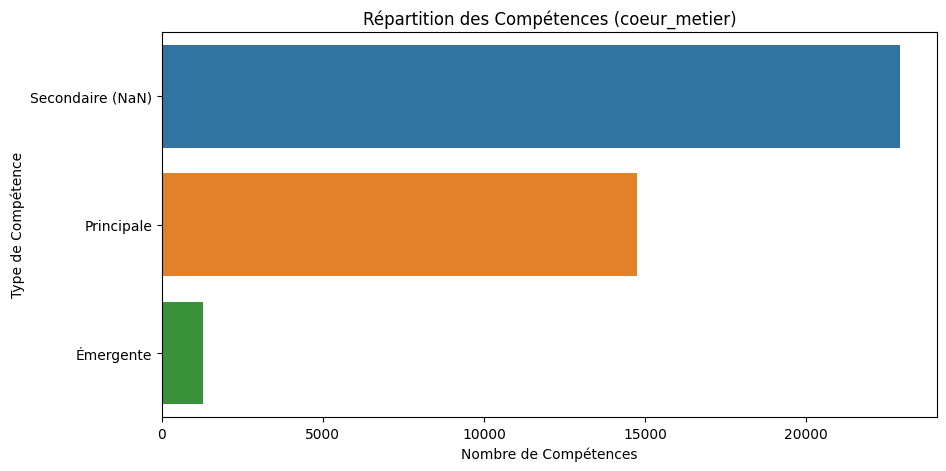

In [53]:
# Visualisation de la répartition des compétences cœur vs secondaires
plt.figure(figsize=(10, 5))
df_tmp = df.copy()
df_tmp['coeur_metier'] = df['coeur_metier'].fillna('Secondaire (NaN)')

sns.countplot(
    data=df_tmp,
    y='coeur_metier',  # <- on passe de x à y
    order=df_tmp['coeur_metier'].value_counts().index,
    hue='coeur_metier'
)

plt.title('Répartition des Compétences (coeur_metier)')
plt.ylabel('Type de Compétence')
plt.xlabel('Nombre de Compétences')
plt.show()

### Lecture du résultat:
La répartition nous indique que la compétence secondaire est la plus répandue. Elle permet de créer une classification des compétences en complément de principale et émergente, tout en ayant un impact moins important.

In [ ]:

# Possible de vérifier si le coeur de métier peut être différent en fonction du code_rome

### 3. Analyse des métiers
 - Top 10 métiers ayant le plus de compétences.
 - Top 10 métiers avec le plus de compétences coeur de métier.
 - Répartition des métiers par emploi_cadre vs non-cadre.
 - Répartition des métiers par impact transition (transition_num_y, transition_eco_y).

       nombre_competences
count           10.000000
mean            65.600000
std              6.834553
min             59.000000
25%             62.000000
50%             63.500000
75%             66.000000
max             82.000000


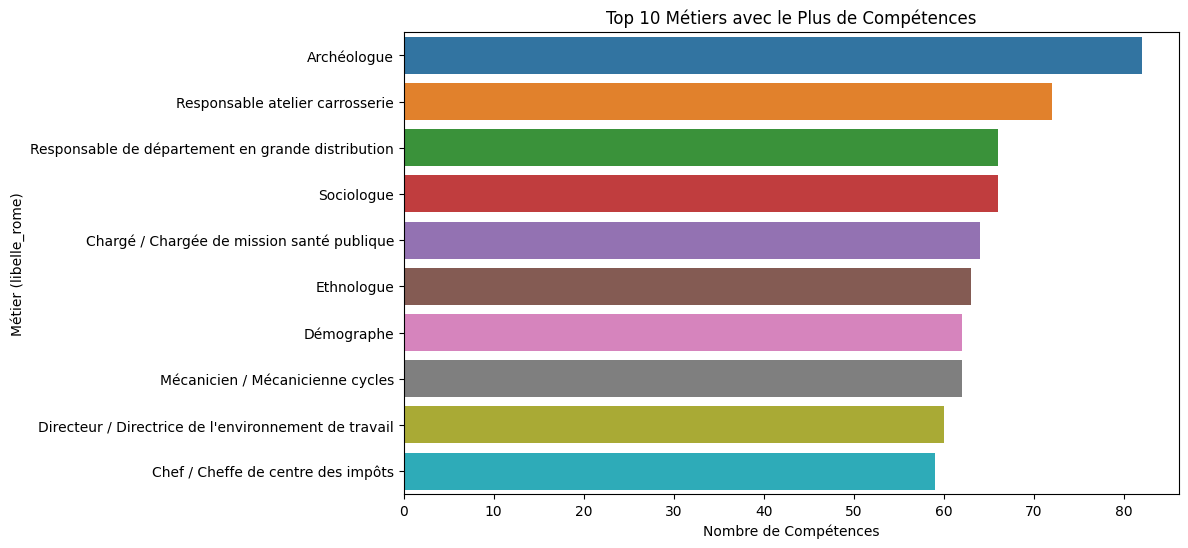

In [ ]:
# 3.1. Top 10 métiers ayant le plus de compétences
# Grouper par code_rome et compter les compétences
competences_par_metier = df.groupby(['code_rome', 'libelle_rome']).size().reset_index(name='nombre_competences')

# Trier par nombre de compétences (décroissant) et prendre les 10 premiers
top_10_metiers_competences = competences_par_metier.sort_values(by='nombre_competences', ascending=False).head(10)
#print("Top 10 métiers avec le plus de compétences :")
#print(top_10_metiers_competences[['code_rome', 'libelle_rome', 'nombre_competences']])
print(competences_par_metier.describe())
 
# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_metiers_competences, x='nombre_competences', y='libelle_rome', hue='libelle_rome')
plt.title('Top 10 Métiers avec le Plus de Compétences')
plt.xlabel('Nombre de Compétences')
plt.ylabel('Métier (libelle_rome)')
plt.show()
 

Nombre de compétences 'Principale' :
       nombre_competences_principale
count                    1579.000000
mean                        9.352755
std                         4.793751
min                         1.000000
25%                         6.000000
50%                         8.000000
75%                        12.000000
max                        40.000000


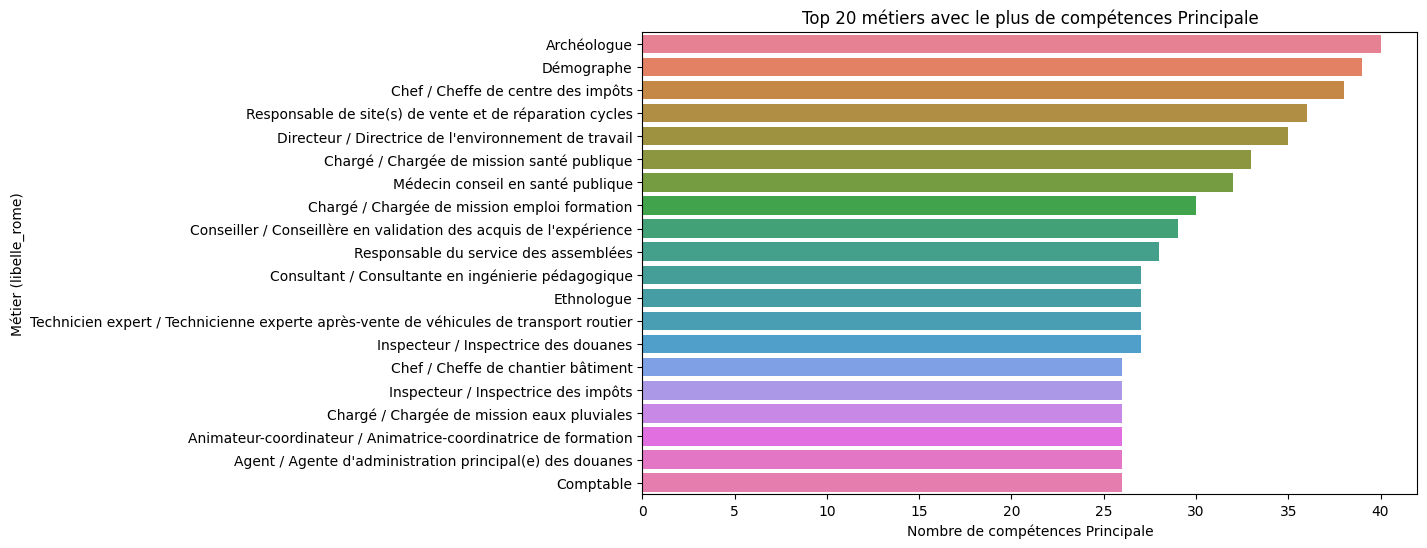

In [93]:
# 3.2. Top 10 métiers avec le plus de compétences coeur de métier 'Principale'
n_top = 20

#========================== Principale ===========================
# Filtrer les compétences où coeur_metier == 'Principale'
competences_principale = df[df['coeur_metier'] == 'Principale']
# Grouper par code_rome et compter
competences_principale_par_metier = competences_principale.groupby(['code_rome', 'libelle_rome']).size().reset_index(name='nombre_competences_principale')
# Trier et prendre les 10 premiers
top_competence_principale = competences_principale_par_metier.sort_values(by='nombre_competences_principale', ascending=False).head(n_top)
print("Nombre de compétences 'Principale' :")
print(competences_principale_par_metier[['code_rome', 'libelle_rome', 'nombre_competences_principale']].describe())

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=top_competence_principale, x='nombre_competences_principale', y='libelle_rome', hue='libelle_rome')
plt.title(f"Top {top_competence_principale.shape[0]} métiers avec le plus de compétences Principale")
plt.xlabel('Nombre de compétences Principale')
plt.ylabel('Métier (libelle_rome)')
plt.show()

Nombre de compétences 'Émergente' :
       nombre_competences_emergente
count                    727.000000
mean                       1.748281
std                        1.136021
min                        1.000000
25%                        1.000000
50%                        1.000000
75%                        2.000000
max                        8.000000


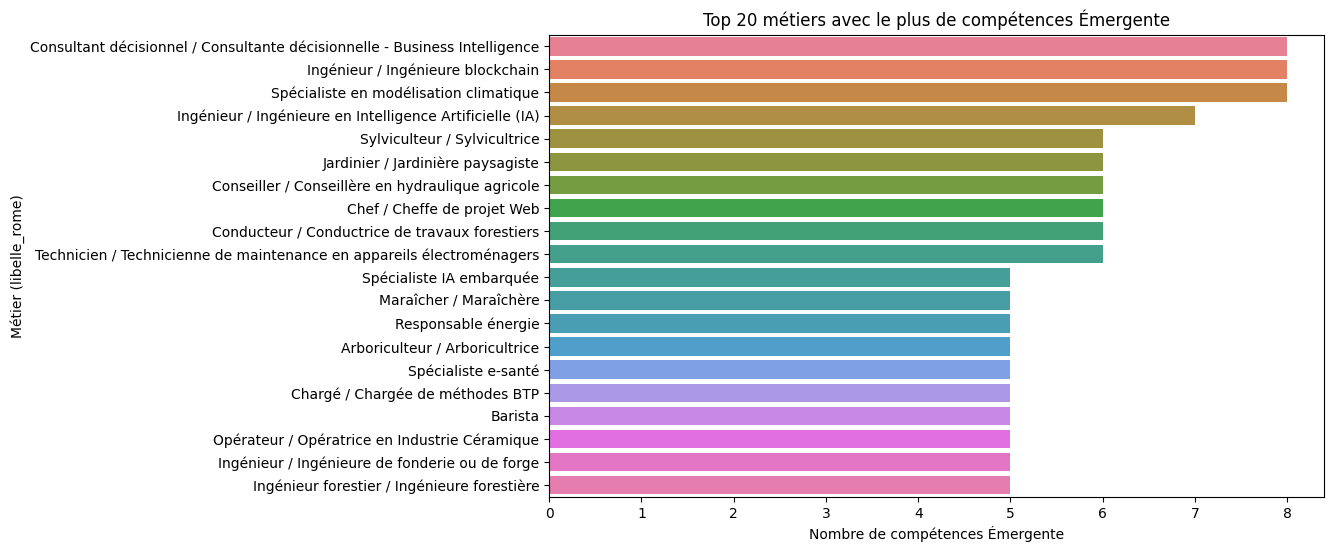

In [94]:
#========================== Émergente ===========================
# Filtrer les compétences où coeur_metier == 'Émergente'
competences_emergente = df[df['coeur_metier'] == 'Émergente']
# Grouper par code_rome et compter
competences_emergente_par_metier = competences_emergente.groupby(['code_rome', 'libelle_rome']).size().reset_index(name='nombre_competences_emergente')
# Trier et prendre les 10 premiers
top_competence_emergente = competences_emergente_par_metier.sort_values(by='nombre_competences_emergente', ascending=False).head(n_top)
print("Nombre de compétences 'Émergente' :")
print(competences_emergente_par_metier.describe())

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=top_competence_emergente, x='nombre_competences_emergente', y='libelle_rome', hue='libelle_rome')
plt.title(f"Top {top_competence_emergente.shape[0]} métiers avec le plus de compétences Émergente")
plt.xlabel('Nombre de compétences Émergente')
plt.ylabel('Métier (libelle_rome)')
plt.show()

Nombre de compétences NaN ou 'Secondaire' :
       nombre_competences_secondaire
count                    1582.000000
mean                       14.489254
std                         7.082121
min                         1.000000
25%                        10.000000
50%                        13.000000
75%                        18.000000
max                        49.000000


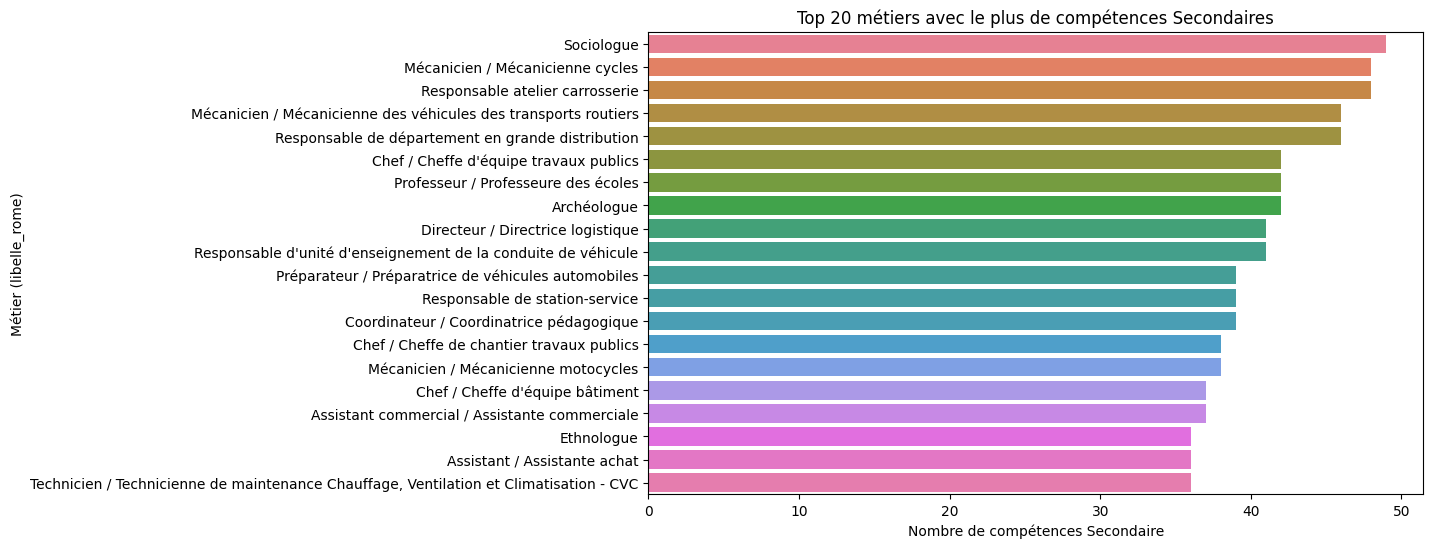

In [95]:
#========================== NaN / Secondaire ===========================
# Filtrer les compétences où coeur_metier == 'Secondaire'
competences_secondaire = df[df['coeur_metier'].isna()] # Secaondaire
# Grouper par code_rome et compter
competences_secondaire_par_metier = competences_secondaire.groupby(['code_rome', 'libelle_rome']).size().reset_index(name='nombre_competences_secondaire')
# Trier et prendre les 10 premiers
top_competence_secondaire = competences_secondaire_par_metier.sort_values(by='nombre_competences_secondaire', ascending=False).head(n_top)
#print(f"\nTop {top_competence_secondaire.shape[0]} métiers avec le plus de compétences 'Secondaire' :")
#print(top_competence_secondaire[['code_rome', 'libelle_rome', 'nombre_competencnombre_competences_secondairees_coeur']])
print("Nombre de compétences NaN ou 'Secondaire' :")
print(competences_secondaire_par_metier.describe())

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=top_competence_secondaire, x='nombre_competences_secondaire', y='libelle_rome', hue='libelle_rome')
plt.title(f"Top {top_competence_secondaire.shape[0]} métiers avec le plus de compétences Secondaires")
plt.xlabel('Nombre de compétences Secondaire')
plt.ylabel('Métier (libelle_rome)')
plt.show()

### Lecture du résultat:
On remarque qu'au dessus de 75% des métiers le nombre de compétences augmente de manière exponentiel.

In [78]:
# 3.3. Répartition des métiers par emploi_cadre vs non-cadre
# Compter les métiers uniques par statut emploi_cadre
df_tmp = df.copy()
df_tmp['emploi_cadre'] = df['emploi_cadre'].fillna('Ni l\'un ni l\'autre')
repartition_cadre = df_tmp.groupby('emploi_cadre')['code_rome'].nunique().reset_index(name='nombre_metiers')
print("\nRépartition des métiers par emploi_cadre :")
print(repartition_cadre)

# Pourcentage
total_metiers = repartition_cadre['nombre_metiers'].sum()
repartition_cadre['pourcentage'] = (repartition_cadre['nombre_metiers'] / total_metiers) * 100
print("\nRépartition en pourcentage :")
print(repartition_cadre[['emploi_cadre', 'nombre_metiers', 'pourcentage']])


Répartition des métiers par emploi_cadre :
         emploi_cadre  nombre_metiers
0                   N             861
1  Ni l'un ni l'autre             174
2                   O             549

Répartition en pourcentage :
         emploi_cadre  nombre_metiers  pourcentage
0                   N             861    54.356061
1  Ni l'un ni l'autre             174    10.984848
2                   O             549    34.659091


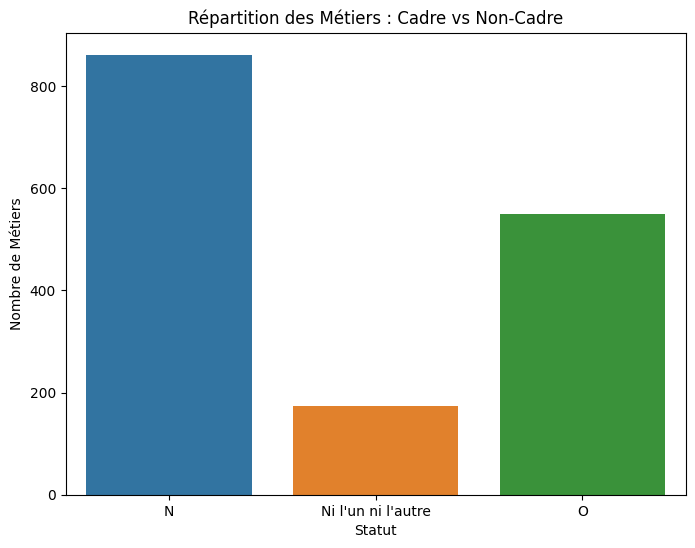

In [81]:
# Visualisation
plt.figure(figsize=(8, 6))
sns.barplot(data=repartition_cadre, x='emploi_cadre', y='nombre_metiers', hue='emploi_cadre')
plt.title('Répartition des Métiers : Cadre vs Non-Cadre')
plt.xlabel('Statut')
plt.ylabel('Nombre de Métiers')
plt.show()

### Lecture du résultat:
- 10.98% des métiers n'ont pas valaur dans la colonne demploi_cadre (=NaN). On suppose qu'ils correspondent aux métiers libéraux ou indépendants.
- Une plus grande proportion des métiers est non cadre.


Métiers dont les compétences ont un impact sur la transition numérique (transition_num_y = 'O') : 949
Métiers dont les compétences n'ont pas d'impact sur la transition numérique (transition_num_y = 'N') : 1578
Métiers dont les compétences sur la transition numérique ne sont pas définies (transition_num_y = NaN) : 1113

Métiers dont les compétences ont un impact sur la transition écologique (transition_eco_y = 'O') : 878
Métiers dont les compétences n'ont pas d'impact sur la transition écologique (transition_eco_y = 'N') : 1345
Métiers dont les compétences sur la transition écologique ne sont pas définies (transition_eco_y = NaN) : 1584


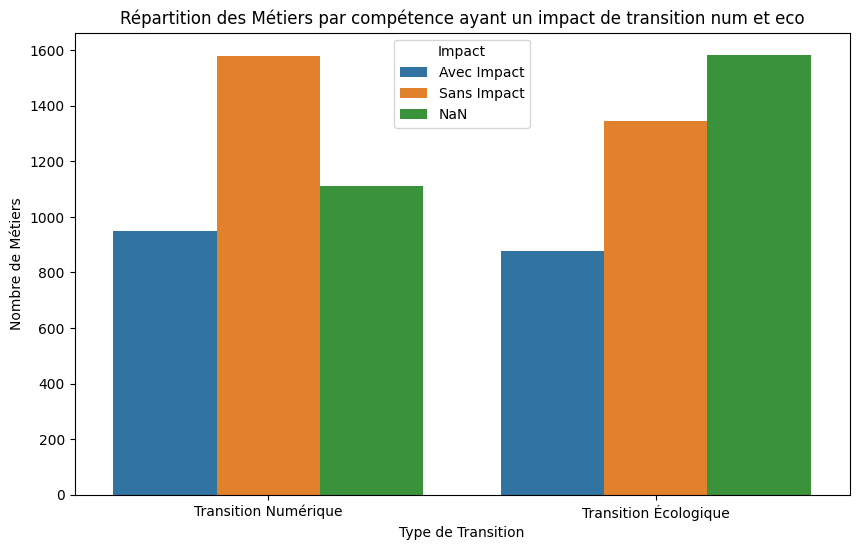

In [88]:
# 3.4. Répartition des métiers par compétence ayant un impact transition (transition_num_y, transition_eco_y)

# Compter les métiers uniques avec transition_num_y = 'O'
metiers_num = df[df['transition_num_y'] == 'O']['code_rome'].nunique()
metiers_non_num = df[df['transition_num_y'] == 'N']['code_rome'].nunique()
metiers_num_na = df[df['transition_num_y'].isna()]['code_rome'].nunique()
print(f"\nMétiers dont les compétences ont un impact sur la transition numérique (transition_num_y = 'O') : {metiers_num}")
print(f"Métiers dont les compétences n'ont pas d'impact sur la transition numérique (transition_num_y = 'N') : {metiers_non_num}")
print(f"Métiers dont les compétences sur la transition numérique ne sont pas définies (transition_num_y = NaN) : {metiers_num_na}")
 
# Compter les métiers uniques avec transition_eco_y = 'O'
metiers_eco = df[df['transition_eco_y'] == 'O']['code_rome'].nunique()
metiers_non_eco = df[df['transition_eco_y'] == 'N']['code_rome'].nunique()
metiers_eco_na = df[df['transition_eco_y'].isna()]['code_rome'].nunique()
print(f"\nMétiers dont les compétences ont un impact sur la transition écologique (transition_eco_y = 'O') : {metiers_eco}")
print(f"Métiers dont les compétences n'ont pas d'impact sur la transition écologique (transition_eco_y = 'N') : {metiers_non_eco}")
print(f"Métiers dont les compétences sur la transition écologique ne sont pas définies (transition_eco_y = NaN) : {metiers_eco_na}")
 
# Visualisation combinée
transition_data = pd.DataFrame({
    'Type': ['Transition Numérique', 'Transition Écologique'],
    'Avec Impact': [metiers_num, metiers_eco],
    'Sans Impact': [metiers_non_num, metiers_non_eco],
    'NaN': [metiers_num_na, metiers_eco_na]
})
transition_data = transition_data.melt(id_vars='Type', 
                                       value_vars=['Avec Impact', 'Sans Impact', 'NaN'], 
                                       var_name='Impact', 
                                       value_name='Nombre de Métiers')
plt.figure(figsize=(10, 6))
sns.barplot(data=transition_data, x='Type', y='Nombre de Métiers', hue='Impact')
plt.title('Répartition des Métiers par compétence ayant un impact de transition num et eco')
plt.xlabel('Type de Transition')
plt.ylabel('Nombre de Métiers')
plt.show()

### Lecture du résultat:
Comme constaté précédemment, les compétences ont trop de valeurs de transition non définie pour pouvoir les utiliser.

### 4. Analyse des compétences

 - Répartition des compétences par catégorie (cat_comp : savoir-faire, savoir etre, connaissance).
 - Répartition des compétences par sous-catégorie (sous_cat_comp).
 - Répartition des compétences par domaine (domaine_competence).
 - Top compétences les plus fréquentes dans les métiers (les plus transversales).

In [99]:
# 4.1: Répartition des compétences par catégorie (cat_comp : savoir-faire, savoir etre, connaissance).
# Comptage des compétences par catégorie
repartition_cat_comp = df['cat_comp'].value_counts(dropna=False).reset_index()
repartition_cat_comp.columns = ['cat_comp', 'nombre_competences']
 
# Pourcentage
repartition_cat_comp['pourcentage'] = (repartition_cat_comp['nombre_competences'] / len(df)) * 100
print("Répartition en pourcentage (cat_comp) :")
print(repartition_cat_comp[['cat_comp', 'nombre_competences', 'pourcentage']])


Répartition en pourcentage (cat_comp) :
       cat_comp  nombre_competences  pourcentage
0  Savoir-faire               38961        100.0


In [101]:
# 4.2: Répartition des compétences par sous-catégorie (sous_cat_comp).
# Comptage des compétences par catégorie
repartition_cat_comp = df['sous_cat_comp'].value_counts(dropna=False).reset_index()
repartition_cat_comp.columns = ['sous_cat_comp', 'nombre_sous_competences']
 
# Pourcentage
repartition_cat_comp['pourcentage'] = (repartition_cat_comp['nombre_sous_competences'] / len(df)) * 100
print("Répartition en pourcentage (sous_cat_comp) :")
print(repartition_cat_comp[['sous_cat_comp', 'nombre_sous_competences', 'pourcentage']])

Répartition en pourcentage (sous_cat_comp) :
      sous_cat_comp  nombre_sous_competences  pourcentage
0  Technique expert                    16666    42.776109
1         Technique                    16507    42.368009
2        Transverse                     5788    14.855882


### Lecture du résultat:
- L’analyse de la colonne cat_comp montre que 100 % des compétences recensées sont classées comme savoir-faire.
- Les compétences sont réparties en 3 sous-catégories.
- Elles sont majoritairement répartient dans les sous-catégories Technique et Technique expert, représentant 85,13 % des compétences. 
- La sous-catégorie Transverse est moins représentée, ce qui suggère qu’elle regroupe des compétences transversales, applicables à plusieurs métiers ou domaines.
 

In [ ]:
# 4.3 Répartition des compétences par domaine (domaine_competence).

Compétences les plus représentées dans les métiers :
       nombre_metiers
count    16583.000000
mean         2.349454
std          3.719186
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        177.000000


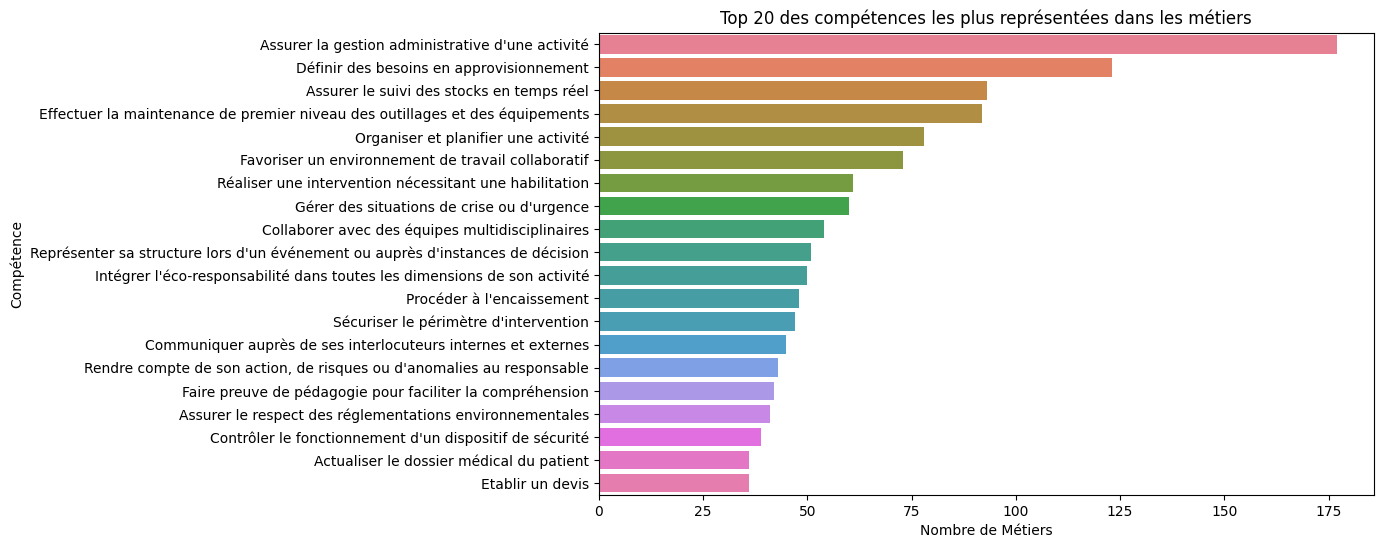

In [132]:
# 4.4. Top compétences les plus fréquentes dans les métiers
# Grouper par code_ogr_competence et libelle_competence, compter les métiers uniques
competences_transversales = df.groupby(['code_ogr_competence', 'libelle_competence'])['code_rome'].nunique().reset_index(name='nombre_metiers')
competences_transversales = df.groupby(['libelle_competence'])['libelle_rome'].nunique().reset_index(name='nombre_metiers')
# Trier et prendre les 10 premières
top_competences_transversales = competences_transversales.sort_values(by='nombre_metiers', ascending=False).head(n_top)
#print("\nTop 10 compétences les plus transversales (présentes dans le plus de métiers) :")
#print(top_competences_transversales[['code_ogr_competence', 'libelle_competence', 'nombre_metiers']])
print(f"Compétences les plus représentées dans les métiers :")
print(competences_transversales.describe())
 
# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=top_competences_transversales, x='nombre_metiers', y='libelle_competence', hue='libelle_competence')
plt.title(f"Top {top_competence_secondaire.shape[0]} des compétences les plus représentées dans les métiers")
plt.xlabel('Nombre de Métiers')
plt.ylabel('Compétence')
plt.show()
 

### Lecture de résultats:
- Sur 16583 compétences, la médiane montre qu'une compétence n'est généralement liée qu'à un seul métier et 75% des compétences apparissent dans deux métiers ou moins. 
- Seule une minorité de compétences très transversales (jusqu'à 177 métiers) représente un socle commun, crucial pour la reconversion professionnelle et l'adaptabilité sur le marché du travail.

### 5. Analyse transition numérique & écologique

- % de compétences numériques par métier.
- % de compétences écologiques par métier.
- Croisement : scatterplot % numérique vs % écologique.
- Identification des métiers en forte transformation (ex. >50% des compétences numériques).

In [147]:
# 5.1. Pourcentage de compétences numériques par métier
# Calculer le nombre total de compétences par métier
total_competences = df.groupby(['code_rome', 'libelle_rome']).size().reset_index(name='total_competences')
# Calculer le nombre de compétences numériques (transition_num_y = 'O')
competences_num = df[df['transition_num_y'] == 'O'].groupby(['code_rome', 'libelle_rome']).size().reset_index(name='competences_num')

# Fusionner et calculer le pourcentage
competences_num = competences_num.merge(total_competences, on=['code_rome', 'libelle_rome'], how='right')
competences_num['pourcentage_num'] = (competences_num['competences_num'] / competences_num['total_competences']) * 100
competences_num['competences_num'] = competences_num['competences_num'].fillna(0)  # Remplacer NaN par 0 pour les métiers sans compétences numériques
competences_num['pourcentage_num'] = competences_num['pourcentage_num'].fillna(0)

# Trier par pourcentage décroissant pour aperçu
#print("\nPourcentage de compétences numériques par métier (extrait des 10 premiers) :")
#print(competences_num.sort_values(by='pourcentage_num', ascending=False)[['code_rome', 'libelle_rome', 'pourcentage_num']].head(10))
print(competences_num.describe())

       competences_num  total_competences  pourcentage_num
count      1584.000000        1584.000000      1584.000000
mean          2.259470          24.596591         9.157401
std           4.018935           9.758396        16.359434
min           0.000000           5.000000         0.000000
25%           0.000000          18.000000         0.000000
50%           1.000000          23.000000         3.846154
75%           2.000000          30.000000         9.090909
max          36.000000          82.000000        93.750000


In [146]:
# 5.2. Pourcentage de compétences écologiques par métier
# Calculer le nombre de compétences écologiques (transition_eco_y = 'O')
competences_eco = df[df['transition_eco_y'] == 'O'].groupby(['code_rome', 'libelle_rome']).size().reset_index(name='competences_eco')
# Fusionner et calculer le pourcentage
competences_eco = competences_eco.merge(total_competences, on=['code_rome', 'libelle_rome'], how='right')
competences_eco['pourcentage_eco'] = (competences_eco['competences_eco'] / competences_eco['total_competences']) * 100
competences_eco['competences_eco'] = competences_eco['competences_eco'].fillna(0)  # Remplacer NaN par 0
competences_eco['pourcentage_eco'] = competences_eco['pourcentage_eco'].fillna(0)
# Trier par pourcentage décroissant pour aperçu
#print("\nPourcentage de compétences écologiques par métier (extrait des 10 premiers) :")
#print(competences_eco.sort_values(by='pourcentage_eco', ascending=False)[['code_rome', 'libelle_rome', 'pourcentage_eco']].head(10))
print(competences_eco.describe())

       competences_eco  total_competences  pourcentage_eco
count      1584.000000        1584.000000      1584.000000
mean          1.510732          24.596591         5.940697
std           2.563387           9.758396         9.739850
min           0.000000           5.000000         0.000000
25%           0.000000          18.000000         0.000000
50%           1.000000          23.000000         3.225806
75%           2.000000          30.000000         7.430556
max          32.000000          82.000000        84.615385


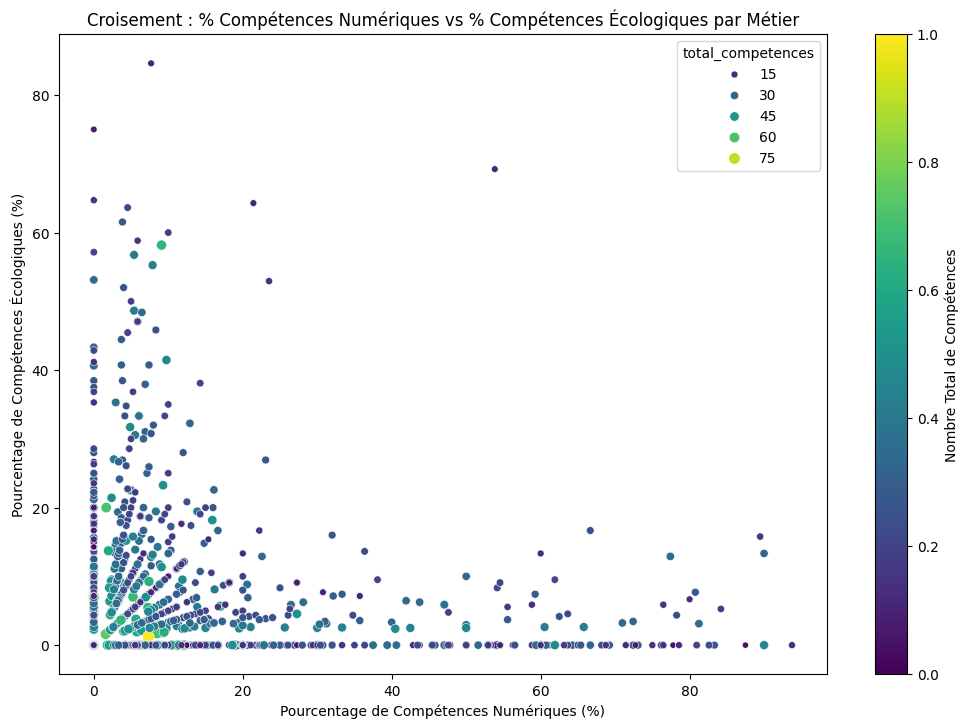

In [148]:
# 5.3. Croisement : Scatterplot % numérique vs % écologique
# Fusionner les données numériques et écologiques, en incluant total_competences
transition_data = competences_num[['code_rome', 'libelle_rome', 'pourcentage_num', 'total_competences']].merge(
    competences_eco[['code_rome', 'libelle_rome', 'pourcentage_eco']],
    on=['code_rome', 'libelle_rome'],
    how='outer'  # Inclure tous les métiers
)
# Créer le scatterplot avec total_competences pour la couleur
plt.figure(figsize=(12, 8))  # Taille augmentée pour plus d'espace
scatter = sns.scatterplot(
    data=transition_data,
    x='pourcentage_num',
    y='pourcentage_eco',
    hue='total_competences',  # Couleur basée sur total_competences
    palette='viridis',  # Palette continue pour les valeurs numériques
    size='total_competences'  # Taille fixe pour tous les points
)
plt.title('Croisement : % Compétences Numériques vs % Compétences Écologiques par Métier')
plt.xlabel('Pourcentage de Compétences Numériques (%)')
plt.ylabel('Pourcentage de Compétences Écologiques (%)')
plt.colorbar(scatter.collections[0], label='Nombre Total de Compétences')  # Ajouter une barre de couleur
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Ajuster les marges manuellement
plt.show()

### Lecture du résultat:
- La majorité des métiers ont peu de compétences numériques ou écologiques. 
- Il n'y a qu'un seul métier hybride qui se démarque (qui apparait sur la diagonale près des 60%).
- Il y a principalement des métiers spécialisés qui se composent soit de compétences numériques, soit de compétences écologiques.


In [162]:
# Recherche du métier isolé (sur la diagonale)
df_transition = transition_data.copy()
df_transition['ecart_num_eco'] = abs(df_transition['pourcentage_num'] - df_transition['pourcentage_eco'])

df_transition['moyene_num_eco'] = (df_transition['pourcentage_num'] + df_transition['pourcentage_eco']) / 2

df_diag = df_transition[df_transition['ecart_num_eco'] < 5]
metier_isole = df_diag.sort_values('moyene_num_eco', ascending= False).head(1)

print(metier_isole[['libelle_rome', 'pourcentage_num', 'pourcentage_eco', 'total_competences']])

                                libelle_rome  pourcentage_num  \
1485  Spécialiste en modélisation climatique        23.076923   

      pourcentage_eco  total_competences  
1485        26.923077                 26  


-> Le métier isolé est: 'Spécialiste en modélisation climatique'

In [ ]:
# 5.4. Identification des métiers en forte transformation (>50% compétences numériques)
# Filtrer les métiers avec >50% de compétences numériques
metiers_forte_transformation_num = transition_data[transition_data['pourcentage_num'] > 50]
print(f"\nMétiers avec >50% de compétences numériques ({len(metiers_forte_transformation_num)} métiers) :")
print(metiers_forte_transformation_num[['code_rome', 'libelle_rome', 'pourcentage_num']].sort_values(by='pourcentage_num', ascending=False))
 
# Optionnel : Métiers avec >50% de compétences écologiques
metiers_forte_transformation_eco = transition_data[transition_data['pourcentage_eco'] > 50]
print(f"\nMétiers avec >50% de compétences écologiques ({len(metiers_forte_transformation_eco)} métiers) :")
print(metiers_forte_transformation_eco[['code_rome', 'libelle_rome', 'pourcentage_eco']].sort_values(by='pourcentage_eco', ascending=False))
 
# Optionnel : Métiers avec >50% pour les deux (numérique ET écologique)
metiers_forte_transformation_both = transition_data[(transition_data['pourcentage_num'] > 50) & (transition_data['pourcentage_eco'] > 50)]
print(f"\nMétiers avec >50% de compétences numériques ET écologiques ({len(metiers_forte_transformation_both)} métiers) :")
print(metiers_forte_transformation_both[['code_rome', 'libelle_rome', 'pourcentage_num', 'pourcentage_eco']])


Métiers avec >50% de compétences numériques (83 métiers) :
     code_rome  \
1479     M1882   
1476     M1879   
1483     M1886   
1473     M1876   
1453     M1856   
1407     M1810   
1445     M1848   
1452     M1855   
1484     M1887   
1491     M1894   
1472     M1875   
1469     M1872   
1468     M1871   
1462     M1865   
1263     L1507   
1481     M1884   
1123     K1906   
1457     M1860   
1463     M1866   
1434     M1837   
1474     M1877   
1470     M1873   
1402     M1805   
1441     M1844   
1418     M1821   
1444     M1847   
1338     M1423   
1480     M1883   
1430     M1833   
1428     M1831   
1446     M1849   
1415     M1818   
1398     M1801   
1447     M1850   
1414     M1817   
1438     M1841   
1416     M1819   
1486     M1889   
286      E1104   
1465     M1868   
1466     M1869   
306      E1124   
1471     M1874   
1431     M1834   
1436     M1839   
283      E1101   
309      E1127   
343      E1406   
1440     M1843   
853      I1405   
1478     M1881   
1403

### 6. Analyse des relations métiers <-> compétences

- Distribution du nombre de métiers par compétence (une compétence peut appartenir à plusieurs métiers).
- Identification des compétences transversales (présentes dans beaucoup de métiers).
- Graphe biparti : métiers (noeuds bleus) ↔ compétences (noeuds verts).   --->> (Histogramme "nb de métiers par compétence".)

In [ ]:
# 6.1. Distribution du nombre de métiers par compétence (une compétence peut appartenir à plusieurs métiers).
competences_transversales

# --> Reste du code de la première version (peut être supprimé)

<Axes: >

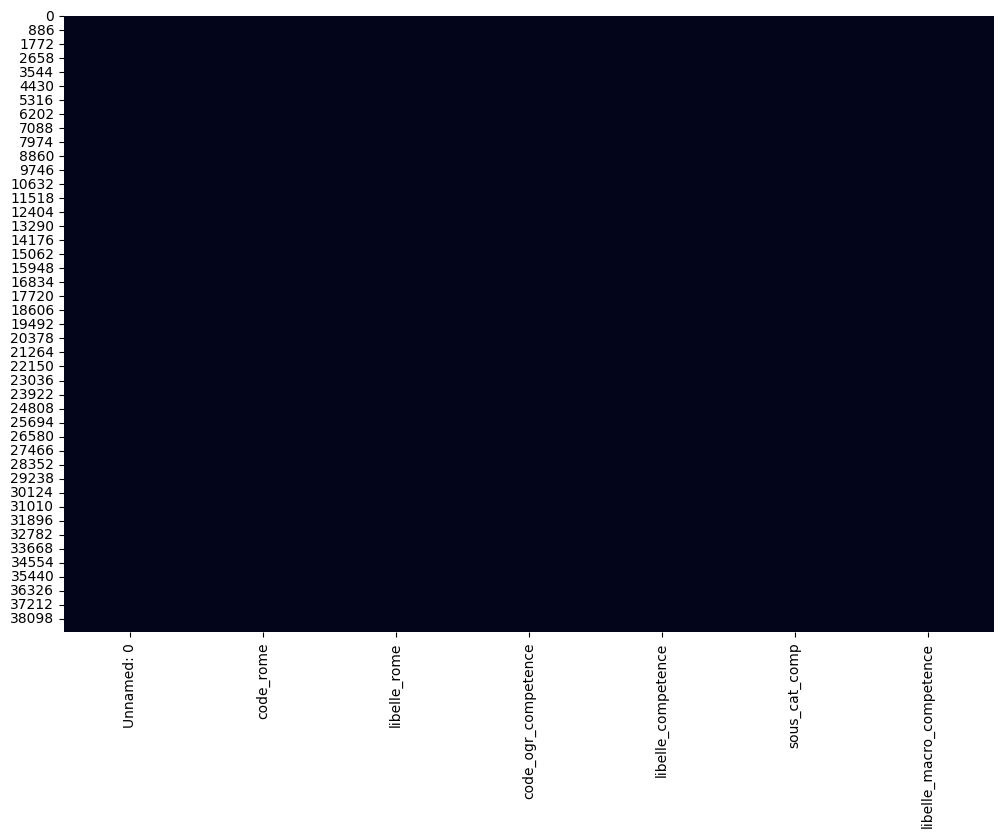

In [49]:
# Identification des valeurs manquantes pour coherence:
# Utilisation de heatmap et isna:
plt.figure(figsize=(12,8))
sns.heatmap(df.isna(), cbar= False)

In [50]:
# Taux de valeur nulles pour coherence:
(df.isna().sum()/df.shape[0]).sort_values(ascending= True)

Unnamed: 0                  0.0
code_rome                   0.0
libelle_rome                0.0
code_ogr_competence         0.0
libelle_competence          0.0
sous_cat_comp               0.0
libelle_macro_competence    0.0
dtype: float64

In [51]:
# On supprime la colonne inutile:
df.drop(columns='Unnamed: 0', axis=0, inplace=True)
df.shape

(38961, 6)

In [52]:
# Affichage des code OGR competence NULL:
df[df['code_ogr_competence'].isna()]

,code_rome,libelle_rome,code_ogr_competence,libelle_competence,sous_cat_comp,libelle_macro_competence


# Examen de la colonne target

In [ ]:
df['code_rome'].value_counts()

code_rome
K2125    82
I1610    72
D1509    66
K2133    66
K1414    64
         ..
H1516     5
N2205     5
K1403     5
C1104     5
C1401     5
Name: count, Length: 1584, dtype: int64

In [ ]:
# Vérification du contenu :
df[df['code_rome'] == 'K2125']

,code_rome,libelle_rome,code_ogr_competence,libelle_competence,sous_cat_comp,libelle_macro_competence
28407,K2125,Archéologue,100486,Déterminer les contraintes techniques de l'oeu...,Technique,Réaliser une étude d'opportunité et de faisabi...
28408,K2125,Archéologue,108520,"Diriger des travaux de recherche (thèse, mémoi...",Technique expert,Conduire des travaux d'études et de recherche
28409,K2125,Archéologue,108521,Conseiller et apporter un appui technique aux ...,Technique expert,Accompagner l'élaboration et la mise en oeuvre...
28410,K2125,Archéologue,108783,"Définir les thèmes, l'objet et la finalité d'é...",Technique expert,"Mettre en oeuvre une stratégie, un plan d'actions"
28411,K2125,Archéologue,108784,Déterminer et développer les méthodes de reche...,Technique expert,Définir et faire évoluer des procédés de trait...
28412,K2125,Archéologue,108787,Etablir un rapport d'étude ou de recherche,Technique expert,Conduire des travaux d'études et de recherche
28413,K2125,Archéologue,108788,Présenter et expliciter les avancées scientifi...,Transverse,Mettre en oeuvre des actions de communication
28414,K2125,Archéologue,115287,Présider ou participer à un jury d'examen,Technique expert,"Evaluer des acquis d'apprentissage, de formati..."
28415,K2125,Archéologue,115350,"Concevoir et coordonner un programme, un proje...",Technique expert,Conduire des travaux d'études et de recherche
28416,K2125,Archéologue,120206,Réaliser une recherche documentaire,Transverse,Réaliser une veille documentaire


In [56]:
df['code_rome'].value_counts(normalize= True)

code_rome
K2125    0.002105
I1610    0.001848
D1509    0.001694
K2133    0.001694
K1414    0.001643
           ...   
H1516    0.000128
N2205    0.000128
K1403    0.000128
C1104    0.000128
C1401    0.000128
Name: proportion, Length: 1584, dtype: float64

# Analyse des variables

In [58]:
# Vue d'ensemble
print("Shape:", df.shape)
print(df.dtypes.value_counts(), "\n")

Shape: (38961, 6)
object    5
int64     1
Name: count, dtype: int64 



In [59]:
df.groupby("libelle_competence")["libelle_rome"].nunique().sort_values(ascending=False).head(20)

libelle_competence
Assurer la gestion administrative d'une activité                                  177
Définir des besoins en approvisionnement                                          123
Assurer le suivi des stocks en temps réel                                          93
Effectuer la maintenance de premier niveau des outillages et des équipements       92
Organiser et planifier une activité                                                78
Favoriser un environnement de travail collaboratif                                 73
Réaliser une intervention nécessitant une habilitation                             61
Gérer des situations de crise ou d'urgence                                         60
Collaborer avec des équipes multidisciplinaires                                    54
Représenter sa structure lors d'un événement ou auprès d'instances de décision     51
Intégrer l'éco-responsabilité dans toutes les dimensions de son activité           50
Procéder à l'encaissement          

In [60]:
df.groupby("libelle_rome")["libelle_competence"].nunique().sort_values(ascending=False).head(20)

libelle_rome
Archéologue                                                82
Responsable atelier carrosserie                            72
Responsable de département en grande distribution          66
Sociologue                                                 66
Chargé / Chargée de mission santé publique                 64
Ethnologue                                                 63
Démographe                                                 62
Mécanicien / Mécanicienne cycles                           62
Directeur / Directrice de l'environnement de travail       60
Chef / Cheffe de centre des impôts                         59
Assistant commercial / Assistante commerciale              58
Styliste                                                   57
Chef / Cheffe de chantier travaux publics                  56
Chargé / Chargée de mission eaux pluviales                 55
Coordinateur / Coordinatrice pédagogique                   55
Secrétaire général / Secrétaire générale                 

In [61]:
df.groupby("libelle_macro_competence")["libelle_rome"].nunique().sort_values(ascending=False).head(20)

libelle_macro_competence
Evaluer, prévenir, et gérer les risques et la sécurité                                450
Rédiger un rapport, un compte rendu d'activité                                        354
Gérer les stocks                                                                      351
Définir et mettre en oeuvre des protocoles de sécurité                                351
Respecter les règles de Qualité, Hygiène, Sécurité, Santé et Environnement (QHSSE)    309
Communiquer à l'oral en milieu professionnel                                          304
Gérer une situation d'urgence                                                         284
Réduire l'empreinte environnementale de son activité                                  279
Développer et piloter un réseau d'organisations partenaires                           273
Réaliser une opération de maintenance                                                 272
Respecter des règles, des consignes, normes et procédures opérationnelles  

### Ce que l'on peut en déduire:
### -> Il faut faire un trie supplémentaire sur les compétences car il y a une sur-représentation de certaines dans les code ROME (métier).
---

(A refaire/compléter)
# Analyse des variables Qualitatives

Dans ce dataset, les variables importantes sont toutes **catégorielles** :  
- `libelle_rome` : métiers (cible de notre prédiction)  
- `libelle_competence` : compétences détaillées  
- `libelle_macro_competence` : familles de compétences  

---

### Distribution de la cible (libelle_rome)
Objectif : vérifier combien de métiers différents sont représentés et observer leur fréquence.  
Cela permet de détecter le **déséquilibre de la cible** (certains métiers très fréquents, beaucoup de métiers rares).

### Distribution des compétences (libelle_competence)
Objectif : identifier les compétences les plus fréquentes (transversales) et celles qui apparaissent rarement (spécifiques).

### Distribution des macro-compétences (libelle_macro_competence)
Objectif : observer quelles familles de compétences dominent dans le dataset.

### Relations métiers ↔ compétences
Objectif : comprendre la richesse et la transversalité :
- combien de compétences différentes par métier,  
- combien de métiers différents par compétence,  
- quels liens forts existent entre métiers et macro-compétences.  

---

### Conclusion intermédiaire
- Toutes les variables sont qualitatives, aucun continu.  
- La cible (métiers) est fortement déséquilibrée.  
- Certaines compétences sont très fréquentes (transversales, peu discriminantes), d’autres rares (spécifiques).  
- Ces constats guideront le prétraitement pour le ML :
  - encodage des variables catégorielles,  
  - gestion du déséquilibre de la cible,  
  - métriques adaptées (balanced accuracy, top-k accuracy).

Nombre de métiers différents : 1584


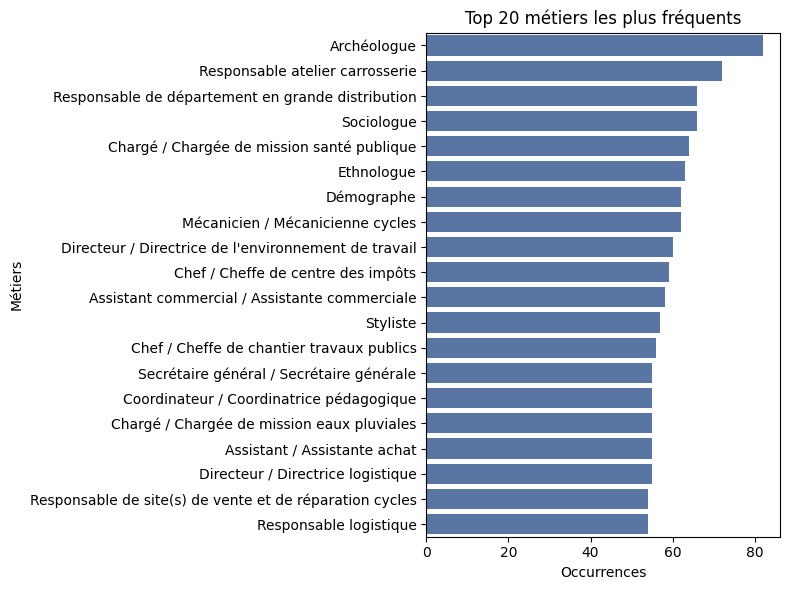

In [62]:
# --- Distribution de la cible (métiers) ---
vc_jobs = df["libelle_rome"].value_counts()
print("Nombre de métiers différents :", vc_jobs.shape[0])
vc_jobs.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=vc_jobs.head(20).values, y=vc_jobs.head(20).index, color="#4C72B0")
plt.title("Top 20 métiers les plus fréquents")
plt.xlabel("Occurrences")
plt.ylabel("Métiers")
plt.tight_layout()
plt.show()

Nombre de compétences différentes : 16583


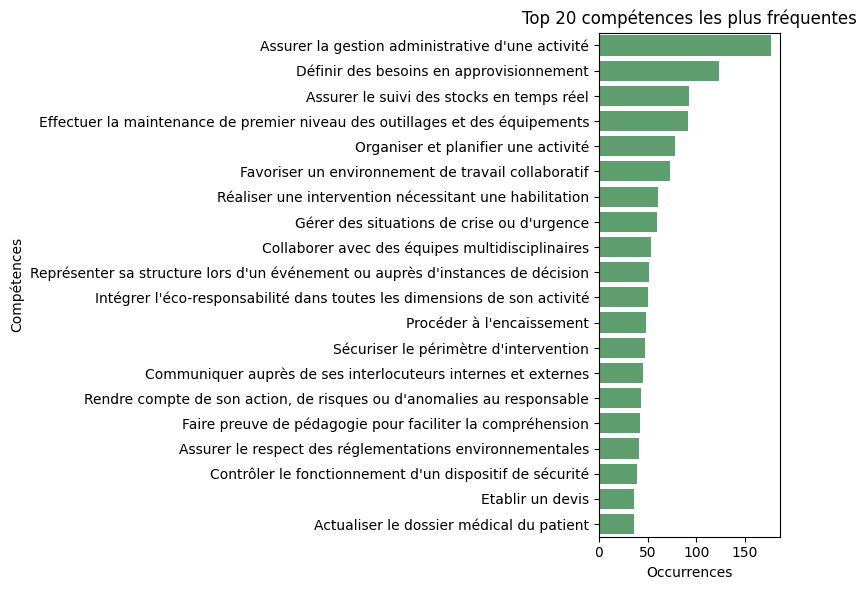

In [64]:
# --- Distribution des compétences ---
vc_comp = df["libelle_competence"].value_counts()
print("Nombre de compétences différentes :", vc_comp.shape[0])
vc_comp.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=vc_comp.head(20).values, y=vc_comp.head(20).index, color="#55A868")
plt.title("Top 20 compétences les plus fréquentes")
plt.xlabel("Occurrences")
plt.ylabel("Compétences")
plt.tight_layout()
plt.show()

Nombre de macro-compétences : 487


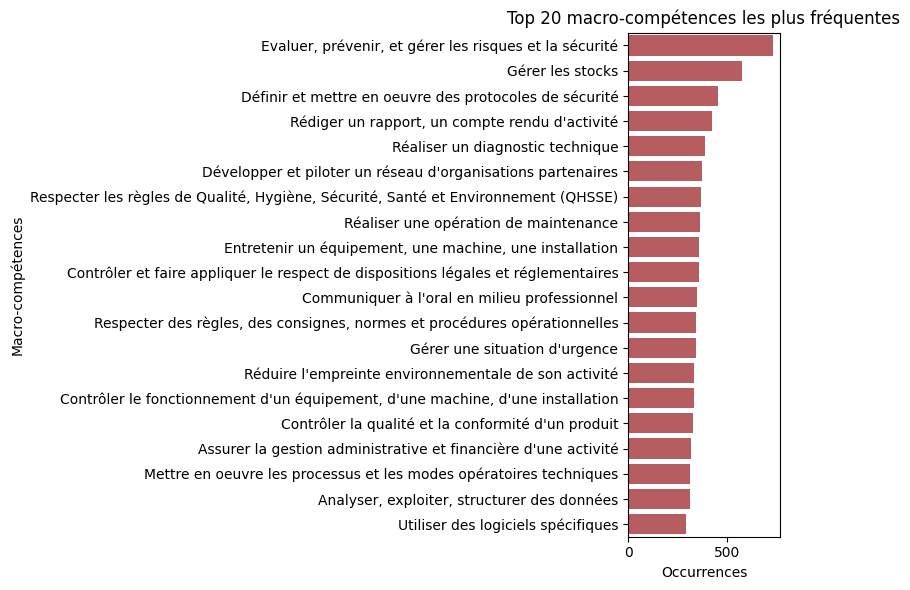

In [65]:
# --- Distribution des macro-compétences ---
vc_macro = df["libelle_macro_competence"].value_counts()
print("Nombre de macro-compétences :", vc_macro.shape[0])

# On garde seulement les 20 plus fréquentes
top_macro = vc_macro.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top_macro.values, y=top_macro.index, color="#C44E52")
plt.title("Top 20 macro-compétences les plus fréquentes")
plt.xlabel("Occurrences")
plt.ylabel("Macro-compétences")
plt.tight_layout()
plt.show()

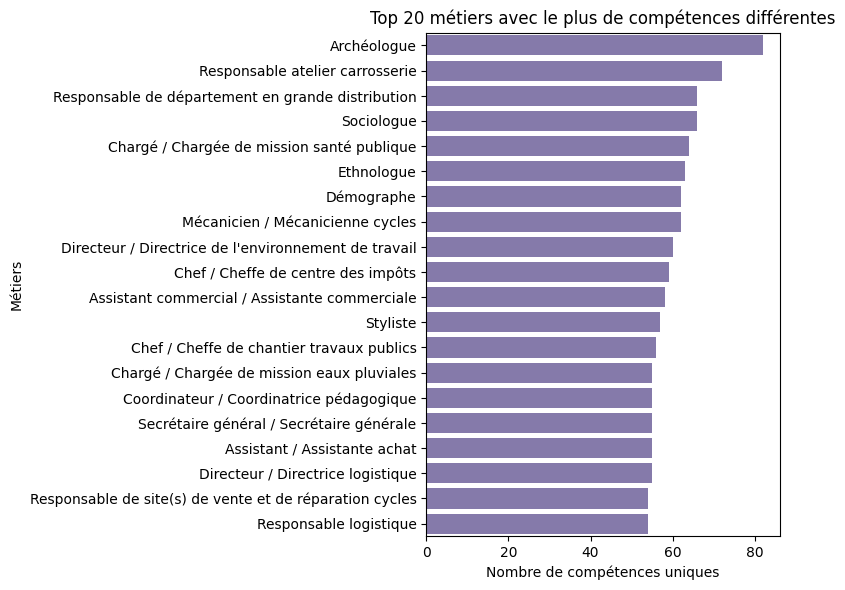

In [66]:
# --- Nb de compétences par métier ---
skills_per_job = df.groupby("libelle_rome")["libelle_competence"].nunique().sort_values(ascending=False)
skills_per_job.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=skills_per_job.head(20).values, y=skills_per_job.head(20).index, color="#8172B2")
plt.title("Top 20 métiers avec le plus de compétences différentes")
plt.xlabel("Nombre de compétences uniques")
plt.ylabel("Métiers")
plt.tight_layout()
plt.show()

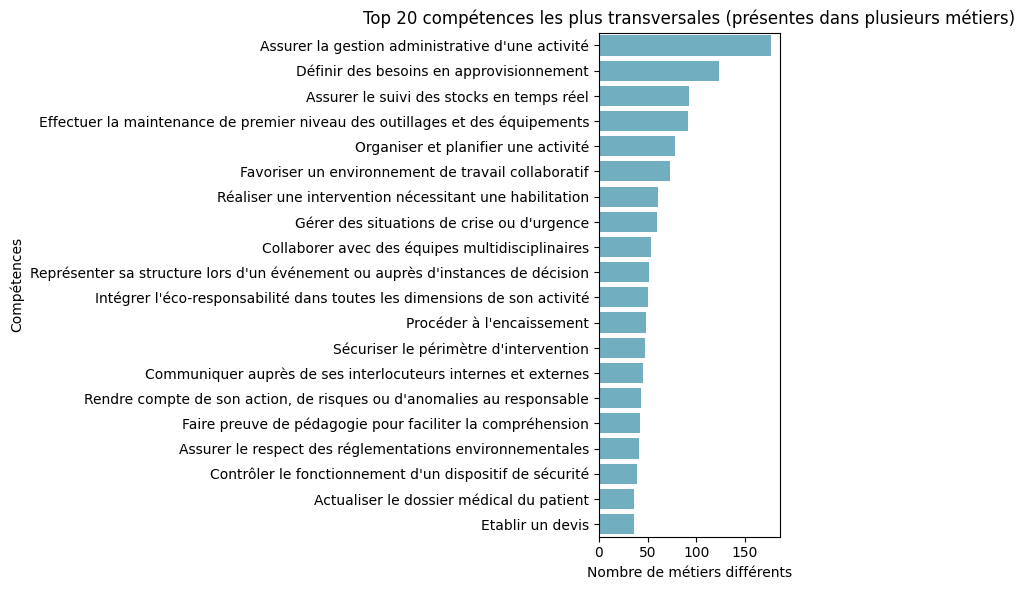

In [67]:
# --- Nb de métiers par compétence ---
jobs_per_skill = df.groupby("libelle_competence")["libelle_rome"].nunique().sort_values(ascending=False)
jobs_per_skill.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=jobs_per_skill.head(20).values, y=jobs_per_skill.head(20).index, color="#64B5CD")
plt.title("Top 20 compétences les plus transversales (présentes dans plusieurs métiers)")
plt.xlabel("Nombre de métiers différents")
plt.ylabel("Compétences")
plt.tight_layout()
plt.show()

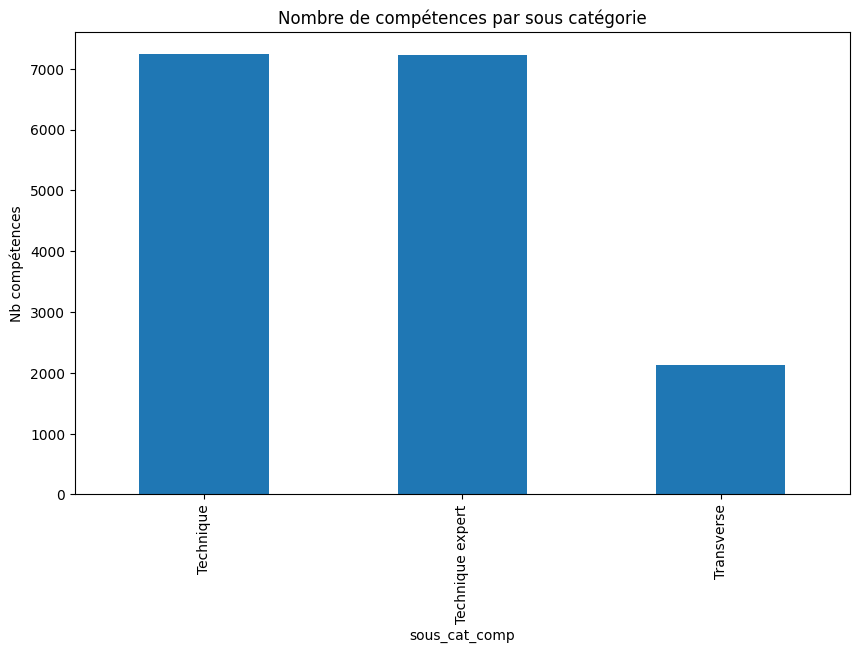

In [80]:
# Compter le nombre de compétences sous-cat
comp_par_sous_cat = (
    df.groupby(["sous_cat_comp"])["libelle_competence"]
    .nunique()
    .sort_index()
)

# Graphique 3 : par sous-catégorie
comp_par_sous_cat.plot(
    kind="bar", figsize=(10,6), title="Nombre de compétences par sous catégorie"
)
plt.ylabel("Nb compétences")
plt.show()

In [81]:
df.groupby(["sous_cat_comp"])["libelle_competence"].count()


sous_cat_comp
Technique           16507
Technique expert    16666
Transverse           5788
Name: libelle_competence, dtype: int64

In [ ]:
# 
df.groupby(["libelle_rome"])["sous_cat_comp"].nunique().sort_index()

# -> Faire la matrice libelle_rome / sous catégorie

np.int64(1584)